# Example of DOV search methods for groundwater samples (grondwatermonsters)


## Use cases:
* Get groundwater samples in a bounding box
* Get groundwater samples with specific properties
* Get the coordinates of all groundwater samples in Ghent
* Get groundwater samples based on a combination of specific properties
* Get groundwater samples based on a selection of screens (filters)

In [1]:
%matplotlib inline
import inspect, sys

In [2]:
# check pydov path
import pydov

## Get information about the datatype 'GrondwaterMonster'

In [3]:
from pydov.search.grondwatermonster import GrondwaterMonsterSearch
gwmonster = GrondwaterMonsterSearch()

A description is provided for the 'GrondwaterMonster' datatype:

In [4]:
print(gwmonster.get_description())

In de Databank Ondergrond Vlaanderen zijn verschillende grondwatermeetnetten opgenomen. Deze meetnetten staan in functie van uitgebreide monitoringprogramma’s met de bedoeling een goed beeld te krijgen van de beschikbare grondwaterkwantiteit en grondwaterkwaliteit van de watervoerende lagen in Vlaanderen.

Deze kaartlaag toont alle watermonsters die in de meetnetten opgenomen zijn.


The different fields that are available for objects of the 'GrondwaterFilter' datatype can be requested with the get_fields() method:

In [5]:
fields = gwmonster.get_fields()

# print available fields
for f in fields.values():
    print(f['name'])

gw_id
filternummer
pkey_filter
grondwatermonsternummer
pkey_grondwatermonster
pkey_grondwaterlocatie
x
y
mv_mtaw
gemeente
datum_monstername
kationen
anionen
zware_metalen
fysico_chemische_parameters
organische_verbindingen
andere_parameters
opdrachten
parameter
eenheid
detectie
waarde
parametergroep
veld_labo


You can get more information of a field by requesting it from the fields dictionary:
* *name*: name of the field
* *definition*: definition of this field
* *cost*: currently this is either 1 or 10, depending on the datasource of the field. It is an indication of the expected time it will take to retrieve this field in the output dataframe.
* *notnull*: whether the field is mandatory or not
* *type*: datatype of the values of this field

In [6]:
# print information for a certain field
fields['waarde']

{'name': 'waarde',
 'type': 'float',
 'definition': 'waarde (numeriek) van de parameter',
 'notnull': False,
 'query': False,
 'cost': 10}

Optionally, if the values of the field have a specific domain the possible values are listed as *values*:

In [7]:
# if an attribute can have several values, these are listed under 'values', e.g. for 'parameter':
fields['parameter']['values']

{'pH': 'parameter Zuurtegraad',
 'EC': 'parameter Elektrische geleidbaarheid',
 'T': 'parameter Temperatuur',
 'Kleur': 'parameter Kleur',
 'Troebelheid': 'parameter Troebelheid',
 'Reuk': 'parameter Reuk',
 'Smaak': 'parameter Smaak',
 'O2': 'parameter Opgeloste zuurstof',
 'Eh°': 'parameter Redoxpotentiaal',
 'COD': 'parameter Chemische zuurstofbehoefte',
 'BOD': 'parameter Biologische zuurstofbehoefte',
 'Verdampingsresten/105': 'parameter Verdampingsresten/105°C',
 'Verassingresten/600': 'parameter Verassingresten/600°C',
 'Zwevende stoffen/105': 'parameter Zwevende stoffen/105°C',
 'Zwevende stoffen/600': 'parameter Zwevende stoffen/600°C',
 'TA': 'parameter Fenolftaleïne-alkaliniteit',
 'TAC': 'parameter Methyloranje-alkaliniteit',
 'Na': 'parameter Natrium',
 'K': 'parameter Kalium',
 'Mg': 'parameter Magnesium',
 'NH4': 'parameter Ammonium',
 'Ca': 'parameter Calcium',
 'Fe': 'parameter Ijzer',
 'Mn': 'parameter Mangaan',
 'Cl': 'parameter Chloriden',
 'SO4': 'parameter Sulfaat

## Example use cases

### Get groundwater samples in a bounding box

Get data for all the groundwater samples that are geographically located within the bounds of the specified box.

The coordinates are in the Belgian Lambert72 (EPSG:31370) coordinate system and are given in the order of lower left x, lower left y, upper right x, upper right y.

In [8]:
from pydov.util.location import Within, Box

df = gwmonster.search(location=Within(Box(93378, 168009, 94246, 169873)))
df.head()

[000/049] ccccccccccccccccccccccccccccccccccccccccccccccccc


,pkey_grondwatermonster,grondwatermonsternummer,pkey_filter,pkey_grondwaterlocatie,gw_id,filternummer,x,y,mv_mtaw,gemeente,datum_monstername,parameter,eenheid,detectie,waarde,parametergroep,veld_labo
0,https://www.dov.vlaanderen.be/data/watermonste...,SWPP006-05547,https://www.dov.vlaanderen.be/data/filter/1999...,https://www.dov.vlaanderen.be/data/put/2018-00...,SWPP006,1,94147.000000,169582.0,9.40,Wortegem-Petegem,1999-05-18,%AfwijkBalans,%,NaN,3.21,Onbekend,LABO
1,https://www.dov.vlaanderen.be/data/watermonste...,SWPP018-05531,https://www.dov.vlaanderen.be/data/filter/1999...,https://www.dov.vlaanderen.be/data/put/2018-00...,SWPP018,1,93789.000000,169132.0,12.38,Wortegem-Petegem,1999-11-15,%AfwijkBalans,%,NaN,1.94,Onbekend,LABO
2,https://www.dov.vlaanderen.be/data/watermonste...,SWPP007-05551,https://www.dov.vlaanderen.be/data/filter/1999...,https://www.dov.vlaanderen.be/data/put/2018-00...,SWPP007,1,94040.000000,169657.0,10.43,Wortegem-Petegem,2000-05-23,%AfwijkBalans,%,NaN,5.44,Onbekend,LABO
3,https://www.dov.vlaanderen.be/data/watermonste...,SWPP017-05529,https://www.dov.vlaanderen.be/data/filter/1999...,https://www.dov.vlaanderen.be/data/put/2017-00...,SWPP017,1,93818.601562,169034.0,10.52,Wortegem-Petegem,2000-05-23,%AfwijkBalans,%,NaN,3.32,Onbekend,LABO
4,https://www.dov.vlaanderen.be/data/watermonste...,SWPP023-36842,https://www.dov.vlaanderen.be/data/filter/2007...,https://www.dov.vlaanderen.be/data/put/2018-00...,SWPP023,1,94053.000000,169638.0,10.09,Wortegem-Petegem,2011-12-21,%AfwijkBalans,%,NaN,1.55,Onbekend,LABO


Using the *pkey* attributes one can request the details of the corresponding *grondwatermonster* in a webbrowser (only showing the first unique records):

In [9]:
for pkey_grondwaterlocatie in df.pkey_grondwatermonster.unique()[0:5]:
    print(pkey_grondwaterlocatie)


https://www.dov.vlaanderen.be/data/watermonster/1999-246645
https://www.dov.vlaanderen.be/data/watermonster/1999-246670
https://www.dov.vlaanderen.be/data/watermonster/2000-246650
https://www.dov.vlaanderen.be/data/watermonster/2000-246669
https://www.dov.vlaanderen.be/data/watermonster/2011-246677


### Get groundwater samples with specific properties

Next to querying groundwater screens based on their geographic location within a bounding box, we can also search for groundwater screens matching a specific set of properties. For this we can build a query using a combination of the 'GrondwaterMonster' fields and operators provided by the WFS protocol.

A list of possible operators can be found below:

In [10]:
[i for i,j in inspect.getmembers(sys.modules['owslib.fes'], inspect.isclass) if 'Property' in i]

['PropertyIsBetween',
 'PropertyIsEqualTo',
 'PropertyIsGreaterThan',
 'PropertyIsGreaterThanOrEqualTo',
 'PropertyIsLessThan',
 'PropertyIsLessThanOrEqualTo',
 'PropertyIsLike',
 'PropertyIsNotEqualTo',
 'PropertyIsNull',
 'SortProperty']

In this example we build a query using the *PropertyIsEqualTo* operator to find all groundwater samples that are within the community (gemeente) of 'Leuven':

In [11]:
from owslib.fes import PropertyIsEqualTo

query = PropertyIsEqualTo(
            propertyname='gemeente',
            literal='Leuven')

df = gwmonster.search(query=query)
df.head()
print(df.size)

[000/165] cccccccccccccccccccccccccccccccccccccccccccccccccc
[050/165] cccccccccccccccccccccccccccccccccccccccccccccccccc
[100/165] cccccccccccccccccccccccccccccccccccccccccccccccccc
[150/165] ccccccccccccccc
84405


Once again we can use the *pkey_grondwatermonster* as a permanent link to the information of the groundwater samples:

In [12]:
for pkey_grondwatermonster in set(df.pkey_grondwatermonster):
    print(pkey_grondwatermonster)

https://www.dov.vlaanderen.be/data/watermonster/2010-060967
https://www.dov.vlaanderen.be/data/watermonster/2014-060982
https://www.dov.vlaanderen.be/data/watermonster/2018-236007
https://www.dov.vlaanderen.be/data/watermonster/2013-060962
https://www.dov.vlaanderen.be/data/watermonster/2013-117396
https://www.dov.vlaanderen.be/data/watermonster/2007-001088
https://www.dov.vlaanderen.be/data/watermonster/2016-243383
https://www.dov.vlaanderen.be/data/watermonster/2001-243381
https://www.dov.vlaanderen.be/data/watermonster/2001-243373
https://www.dov.vlaanderen.be/data/watermonster/2018-241372
https://www.dov.vlaanderen.be/data/watermonster/2015-117393
https://www.dov.vlaanderen.be/data/watermonster/2015-117390
https://www.dov.vlaanderen.be/data/watermonster/2010-117366
https://www.dov.vlaanderen.be/data/watermonster/2015-121866
https://www.dov.vlaanderen.be/data/watermonster/2010-095562
https://www.dov.vlaanderen.be/data/watermonster/2011-117367
https://www.dov.vlaanderen.be/data/water

### Get all groundwater samples in Leuven

In [13]:
query = PropertyIsEqualTo(propertyname='gemeente',
                          literal='Leuven')

df = gwmonster.search(query=query)
df.head()

[000/165] cccccccccccccccccccccccccccccccccccccccccccccccccc
[050/165] cccccccccccccccccccccccccccccccccccccccccccccccccc
[100/165] cccccccccccccccccccccccccccccccccccccccccccccccccc
[150/165] ccccccccccccccc


,pkey_grondwatermonster,grondwatermonsternummer,pkey_filter,pkey_grondwaterlocatie,gw_id,filternummer,x,y,mv_mtaw,gemeente,datum_monstername,parameter,eenheid,detectie,waarde,parametergroep,veld_labo
0,https://www.dov.vlaanderen.be/data/watermonste...,2-0005/M2009,https://www.dov.vlaanderen.be/data/filter/1974...,https://www.dov.vlaanderen.be/data/put/2017-00...,2-0005,1,171548.64,172680.85,26.21,Leuven,2009-12-14,T,°C,NaN,10.50,Fysico-chemische parameters,VELD
1,https://www.dov.vlaanderen.be/data/watermonste...,2-0005/M2009,https://www.dov.vlaanderen.be/data/filter/1974...,https://www.dov.vlaanderen.be/data/put/2017-00...,2-0005,1,171548.64,172680.85,26.21,Leuven,2009-12-14,NO3,mg/l,<,0.20,Anionen,LABO
2,https://www.dov.vlaanderen.be/data/watermonste...,2-0005/M2009,https://www.dov.vlaanderen.be/data/filter/1974...,https://www.dov.vlaanderen.be/data/put/2017-00...,2-0005,1,171548.64,172680.85,26.21,Leuven,2009-12-14,EC,µS/cm,NaN,759.00,Fysico-chemische parameters,VELD
3,https://www.dov.vlaanderen.be/data/watermonste...,2-0005/M2009,https://www.dov.vlaanderen.be/data/filter/1974...,https://www.dov.vlaanderen.be/data/put/2017-00...,2-0005,1,171548.64,172680.85,26.21,Leuven,2009-12-14,O2,mg/l,<,0.20,Fysico-chemische parameters,VELD
4,https://www.dov.vlaanderen.be/data/watermonste...,2-0005/M2009,https://www.dov.vlaanderen.be/data/filter/1974...,https://www.dov.vlaanderen.be/data/put/2017-00...,2-0005,1,171548.64,172680.85,26.21,Leuven,2009-12-14,HCO3,mg/l,NaN,176.96,Anionen,LABO


## Get groundwater screens based on a combination of specific properties

Get all groundwater screens in Hamme that have measurements for cations (kationen). And filter to get only Sodium values after fetching all records.

In [14]:
from owslib.fes import Or, Not, PropertyIsNull, PropertyIsLessThanOrEqualTo, And, PropertyIsLike

query = And([PropertyIsEqualTo(propertyname='gemeente',
                               literal='Hamme'),
             PropertyIsEqualTo(propertyname='kationen',
                               literal='true')
             ])
df_hamme = gwmonster.search(query=query,
                     return_fields=('pkey_grondwatermonster', 'parameter', 'parametergroep', 'waarde', 'datum_monstername'))
df_hamme.head()

[000/263] cccccccccccccccccccccccccccccccccccccccccccccccccc
[050/263] cccccccccccccccccccccccccccccccccccccccccccccccccc
[100/263] cccccccccccccccccccccccccccccccccccccccccccccccccc
[150/263] cccccccccccccccccccccccccccccccccccccccccccccccccc
[200/263] cccccccccccccccccccccccccccccccccccccccccccccccccc
[250/263] ccccccccccccc


,pkey_grondwatermonster,datum_monstername,parameter,waarde,parametergroep
0,https://www.dov.vlaanderen.be/data/watermonste...,2011-03-28,pH(Lab.),6.90,Fysico-chemische parameters
1,https://www.dov.vlaanderen.be/data/watermonste...,2011-03-28,Cr,5.00,Zware metalen
2,https://www.dov.vlaanderen.be/data/watermonste...,2011-03-28,F,0.13,Anionen
3,https://www.dov.vlaanderen.be/data/watermonste...,2011-03-28,Na,66.20,Kationen
4,https://www.dov.vlaanderen.be/data/watermonste...,2011-03-28,O2,0.27,Fysico-chemische parameters


You should note that this initial dataframe contains all parameters (not just the cations). The filter will only make sure that only samples were any cation was analysed are in the list. If we want to filter more, we should do so in the resulting dataframe.

In [15]:
df_hamme = df_hamme[df_hamme.parameter=='Na']
df_hamme.head()

,pkey_grondwatermonster,datum_monstername,parameter,waarde,parametergroep
3,https://www.dov.vlaanderen.be/data/watermonste...,2011-03-28,Na,66.2,Kationen
57,https://www.dov.vlaanderen.be/data/watermonste...,2009-03-13,Na,70.5,Kationen
71,https://www.dov.vlaanderen.be/data/watermonste...,2014-02-25,Na,350.0,Kationen
124,https://www.dov.vlaanderen.be/data/watermonste...,2009-12-23,Na,61.2,Kationen
159,https://www.dov.vlaanderen.be/data/watermonste...,2009-03-13,Na,364.4,Kationen


## Working with water samples

For further analysis and visualisation of the time series data, we can use the data analysis library [pandas](https://pandas.pydata.org/) and visualisation library [matplotlib](https://matplotlib.org/). 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

Query the data of a specific filter using its `pkey`:

In [17]:
query = PropertyIsEqualTo(
            propertyname='pkey_filter',
            literal='https://www.dov.vlaanderen.be/data/filter/1991-001040')

df = gwmonster.search(query=query)
df.head()

[000/009] ccccccccc


,pkey_grondwatermonster,grondwatermonsternummer,pkey_filter,pkey_grondwaterlocatie,gw_id,filternummer,x,y,mv_mtaw,gemeente,datum_monstername,parameter,eenheid,detectie,waarde,parametergroep,veld_labo
0,https://www.dov.vlaanderen.be/data/watermonste...,4-0076/M2010,https://www.dov.vlaanderen.be/data/filter/1991...,https://www.dov.vlaanderen.be/data/put/2017-00...,4-0076,1,133977.0,199147.0,4.65,Hamme,2011-03-28,pH(Lab.),Sörensen,NaN,6.90,Fysico-chemische parameters,LABO
1,https://www.dov.vlaanderen.be/data/watermonste...,4-0076/M2010,https://www.dov.vlaanderen.be/data/filter/1991...,https://www.dov.vlaanderen.be/data/put/2017-00...,4-0076,1,133977.0,199147.0,4.65,Hamme,2011-03-28,Cr,µg/l,<,5.00,Zware metalen,LABO
2,https://www.dov.vlaanderen.be/data/watermonste...,4-0076/M2010,https://www.dov.vlaanderen.be/data/filter/1991...,https://www.dov.vlaanderen.be/data/put/2017-00...,4-0076,1,133977.0,199147.0,4.65,Hamme,2011-03-28,F,mg/l,NaN,0.13,Anionen,LABO
3,https://www.dov.vlaanderen.be/data/watermonste...,4-0076/M2010,https://www.dov.vlaanderen.be/data/filter/1991...,https://www.dov.vlaanderen.be/data/put/2017-00...,4-0076,1,133977.0,199147.0,4.65,Hamme,2011-03-28,Na,mg/l,NaN,66.20,Kationen,LABO
4,https://www.dov.vlaanderen.be/data/watermonste...,4-0076/M2010,https://www.dov.vlaanderen.be/data/filter/1991...,https://www.dov.vlaanderen.be/data/put/2017-00...,4-0076,1,133977.0,199147.0,4.65,Hamme,2011-03-28,O2,mg/l,NaN,0.27,Fysico-chemische parameters,LABO


The date is still stored as a string type. Transforming to a data type using the available pandas function [`to_datetime`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) and using these dates as row index:

In [18]:
df['datum_monstername'] = pd.to_datetime(df['datum_monstername'])

For many usecases, it is useful to create a pivoted table, showing the value per parameter

In [19]:
pivot = df.pivot_table(columns=df.parameter, values='waarde', index='datum_monstername')
pivot

parameter,%AfwijkBalans,Al,As,B,CO3,Ca,Cd,Cl,Co,Cr,...,PO4(Tot.),Pb,SO4,SomAN,SomKAT,T,TOC,Zn,pH,pH(Lab.)
datum_monstername,,,,,,,,,,,,,,,,,,,,,
2006-05-24,NaN,0.0500,5.000,NaN,NaN,399.0000,0.500,108.0000,NaN,2.1,...,0.1,5.0,488.0000,NaN,NaN,13.90,58.000,16.0000,6.70,NaN
2009-03-13,NaN,NaN,5.000,NaN,1.0,394.7000,0.500,96.0000,NaN,10.0,...,NaN,10.0,431.0000,NaN,NaN,12.70,8.585,10.0000,6.76,6.80
2009-12-23,NaN,NaN,12.467,NaN,1.0,447.2000,0.500,105.0000,NaN,5.0,...,NaN,5.0,433.6000,NaN,NaN,10.80,8.902,24.9390,7.04,6.90
2011-03-28,NaN,NaN,12.998,NaN,1.0,331.1000,0.519,107.0000,NaN,5.0,...,NaN,5.0,290.1000,NaN,NaN,12.00,9.984,12.9790,6.70,6.90
2011-11-04,NaN,NaN,8.400,112.0,1.0,345.0000,0.500,99.0000,5.00,5.0,...,NaN,5.0,385.4900,NaN,NaN,12.10,8.337,10.9000,6.73,7.40
2012-11-26,NaN,NaN,NaN,NaN,1.0,360.0000,NaN,95.0000,NaN,NaN,...,NaN,NaN,313.0000,NaN,NaN,12.70,7.784,NaN,6.61,7.18
2014-02-25,NaN,NaN,2.000,100.0,1.0,330.0000,0.030,91.0000,0.57,1.0,...,NaN,2.0,190.0000,NaN,NaN,12.40,7.500,5.0000,6.82,7.10
2014-09-30,NaN,0.0200,2.300,100.0,1.0,280.0000,0.030,87.7459,0.65,1.0,...,NaN,2.0,143.2035,NaN,NaN,12.40,5.800,5.0000,6.82,6.90
2015-09-30,-6.0485,0.0486,5.000,115.5,1.0,299.4059,0.500,88.8800,5.00,5.0,...,NaN,5.0,171.1500,22.3459,19.7969,11.99,9.188,47.2927,6.68,6.80


### Plotting

The default plotting functionality of Pandas can be used:

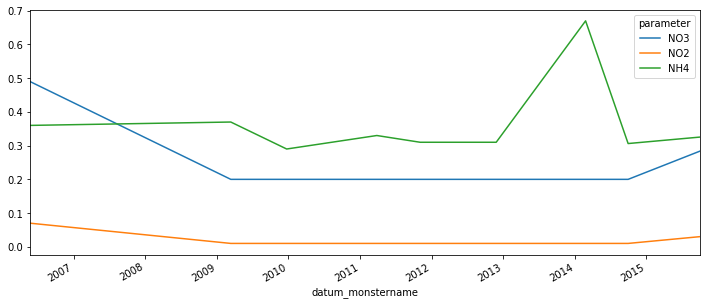

In [20]:
parameters = ['NO3', 'NO2', 'NH4']
pivot[parameters].plot(style='-', figsize=(12, 5))

## Combine search in filters and groundwater samples

For this example, we will first search filters, and later search all samples for this selection. 
We will select filters in the primary network located in Kalmthout.

In [21]:
from pydov.search.grondwaterfilter import GrondwaterFilterSearch
from pydov.util.query import Join

gfs = GrondwaterFilterSearch()

gemeente = 'Kalmthout'
filter_query = And([PropertyIsLike(propertyname='meetnet',
                       literal='meetnet 1 %'),
                    PropertyIsEqualTo(propertyname='gemeente',
                       literal=gemeente)])

filters = gfs.search(query=filter_query, return_fields=['pkey_filter'])

#filters = gfs.search(query=query,
#                     location=Within(Box(87676, 163442, 91194, 168043)))

monsters = gwmonster.search(query=Join(filters, 'pkey_filter'))
monsters.head()

[000/153] cccccccccccccccccccccccccccccccccccccccccccccccccc
[050/153] cccccccccccccccccccccccccccccccccccccccccccccccccc
[100/153] cccccccccccccccccccccccccccccccccccccccccccccccccc
[150/153] ccc


,pkey_grondwatermonster,grondwatermonsternummer,pkey_filter,pkey_grondwaterlocatie,gw_id,filternummer,x,y,mv_mtaw,gemeente,datum_monstername,parameter,eenheid,detectie,waarde,parametergroep,veld_labo
0,https://www.dov.vlaanderen.be/data/watermonste...,1-0409/M2006,https://www.dov.vlaanderen.be/data/filter/1981...,https://www.dov.vlaanderen.be/data/put/2017-00...,1-0409,1,154510.0,228040.0,21.29,Kalmthout,2006-05-05,Fe2+,mg/l,NaN,18.799999,Kationen,LABO
1,https://www.dov.vlaanderen.be/data/watermonste...,1-0409/M2006,https://www.dov.vlaanderen.be/data/filter/1981...,https://www.dov.vlaanderen.be/data/put/2017-00...,1-0409,1,154510.0,228040.0,21.29,Kalmthout,2006-05-05,Pb,µg/l,<,5.000000,Zware metalen,LABO
2,https://www.dov.vlaanderen.be/data/watermonste...,1-0409/M2006,https://www.dov.vlaanderen.be/data/filter/1981...,https://www.dov.vlaanderen.be/data/put/2017-00...,1-0409,1,154510.0,228040.0,21.29,Kalmthout,2006-05-05,Al,mg/l,NaN,1.040000,Zware metalen,LABO
3,https://www.dov.vlaanderen.be/data/watermonste...,1-0409/M2006,https://www.dov.vlaanderen.be/data/filter/1981...,https://www.dov.vlaanderen.be/data/put/2017-00...,1-0409,1,154510.0,228040.0,21.29,Kalmthout,2006-05-05,Cl,mg/l,NaN,43.900002,Anionen,LABO
4,https://www.dov.vlaanderen.be/data/watermonste...,1-0409/M2006,https://www.dov.vlaanderen.be/data/filter/1981...,https://www.dov.vlaanderen.be/data/put/2017-00...,1-0409,1,154510.0,228040.0,21.29,Kalmthout,2006-05-05,K,mg/l,NaN,4.100000,Kationen,LABO


We will filter out some parameters, and show trends per location.

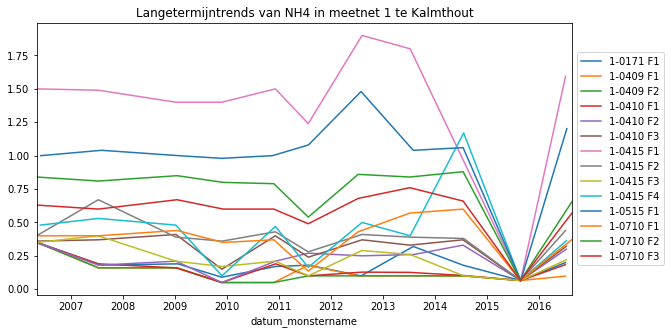

In [22]:
parameter = 'NH4'
trends_sel = monsters[(monsters.parameter==parameter) & (monsters.veld_labo=='LABO')]
trends_sel = trends_sel.set_index( 'datum_monstername')
trends_sel['label'] = trends_sel['gw_id'] + ' F' + trends_sel['filternummer'] 
# trends_sel['waarde'].unstack(level=0).plot()

ax = trends_sel.groupby('label')['waarde'].plot(figsize=(12, 5))

plt.title('Langetermijntrends van %s in meetnet 1 te %s' % (parameter, gemeente))

# Put a legend to the right of the current axis
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
